# Semibatch Operation and Thermal Safety 

## Introduction

Semibatch processes are widely employed in the polymer industry due to their inherent flexibility, which enables precise control of reaction conditions and polymer properties. In this notebook, we will illustrate the basic principles needed to model these systems by examining a classical radical solution homopolymerization, based on the reaction scheme outlined in [Notebook 5]. 

We assume a single-phase, well-stirred tank reactor where the mole balances for the species involved can be expressed as:

$$ \frac{\textrm{d}n_i}{\textrm{d}t} = \dot{n}^{in}_{i} + r_i V $$

Here, $n_i$, $\dot{n}^{in}_{i}$ and $r_i$ denote, respectively, the number of moles, the molar inflow, and the rate of production of species $i$, while $V$ represents the volume of the reaction mixture. The relevant species in our case include the initiator ($I$), monomer ($M$), optional solvent ($S$), radicals ($R^{\cdot}_n$), and dead polymer ($P_n$). Let us further suppose that we are only interested in the average polymer chain length, rather than in the full molar mass distribution. In this scenario, the **method of moments** can be used to reduce the complexity of the model. Specifically, we focus on the first three moments of the radical and polymer distributions:

\begin{align*}
\mu_j     & = \sum_{n=1}^{\infty} n^j [R_n^{\cdot}] \\
\lambda_j & = \sum_{n=1}^{\infty} n^j [P_n]
\end{align*}

with $j \in \{0,1,2\}$. As a result, the model will consist of molar balances for three species ($I$, $M$, $S$) and six pseudo-species ($\mu_0$, $\mu_1$, $\mu_2$,  $\lambda_0$, $\lambda_1$, and $\lambda_2$). The corresponding rates of formation are:  

\begin{align*}
r_{I} & = - k_d [I] \\
r_{M} & = - (k_p [M] \mu_0 + 2 f k_d [I]) \\
r_{S} & = 0 \\
r_{\mu_0} & = 2 f k_d [I] - 2 k_t \mu_0^2 \\
r_{\mu_1} & = 2 f k_d [I] + k_p [M] \mu_0 - 2 k_t \mu_0 \mu_1 \\
r_{\mu_2} & = 2 f k_d [I] + k_p [M] (\mu_0 + 2 \mu_1) - 2 k_t \mu_0 \mu_2 \\
r_{\lambda_0} & = (k_{tc} + 2 k_{td}) \mu_0^2 \\
r_{\lambda_1} & = 2 k_{t} \mu_0 \mu_1 \\
r_{\lambda_2} & = 2 k_{t} \mu_0 \mu_2 + 2 k_{tc} \mu_1^2
\end{align*}

The volume of the reaction mixture can be evaluated from the calculated mole amounts of monomer, solvent and polymer repeating units (initiator neglected):

$$ V \approx n_M \frac{MW_M}{\rho_M} + n_S \frac{MW_S}{\rho_S} + (n_{\mu_1} + n_{\lambda_1})\frac{MW_M}{\rho_P} $$

where $MW_i$ and $\rho_i$ represent, respectively, the molar mass and density of species $i$.

Given that chain-growth reactions are strongly exothermal, the model would not be complete without an energy balance:

$$ m_t c_p \frac{\textrm{d}T}{\textrm{d}t} = \dot{m}_{in} c_p (T_{in} - T) + (-r_M)  V (-\Delta H_{pol}) + UA(T_j - T)$$

where $m_t$ is the total mass of the reaction mixture, $c_p$ is the average specific heat capacity of the reaction mixture and feed, $\dot{m}_{in}$ is the total inlet mass flowrate, $T_{in}$ is the mean feed temperature, $\Delta H_{pol}$ is the polymerization enthalpy, $U$ is the overall heat transfer coefficient, $A$ is the heat transfer area, and $T_j$ is the jacket temperature. We assume the jacket temperature is automatically adjusted by means of a simple proportional-only controller:

$$ T_j = T_{sp} - K_P(T - T_{sp}) $$

where $T_{sp}(t)$ is the reactor temperature setpoint. Additionally, we also estimate the maximum temperature of the synthesis reaction (MTSR), which is an important safety quantity:

$$ MTSR = T + \frac{n_M (-\Delta H_{pol})}{m_t c_p} $$

**Note**: One sometimes encounters semibatch models formulated with concentrations and volume as state variables. This can lead to unnecessary numerical issues (can you think of two examples?) and should be avoided. The state variables should preferably be extensive quantities like mass or moles, the latter having the advantage of working also for massless pseudo-species.

[Notebook 5]: 5_radical_polymerization.ipynb


## Numerical Solution

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

### Model Equations

This model is more complex than the preceding ones, so it is essential to organize the code in a modular way. We will begin by implementing a helper function `arrhenius` to describe the temperature dependence of the rate coefficients.

In [2]:
def arrhenius(T: float, k0: float, E: float, T0: float) -> float:
    """Arrhenius equation.

    Parameters
    ----------
    T : float
        Temperature (°C).
    k0 : float
        Value of rate coefficient at `T0` (#/s).
    E : float
        Energy of activation (J/mol).
    T0 : float
        Reference temperature (°C).

    Returns
    -------
    float
        Value of rate coefficient at `T`.
    """
    R = 8.314  # J/(mol.K)
    return k0 * np.exp(-E / R * (1/(273.15 + T) - 1/(273.15 + T0)))

To improve code readability, we define _named_ variables that point to the corresponding row index in the state vector and related arrays.

In [3]:
idx_I   = 0
idx_M   = 1
idx_S   = 2
idx_mu0 = 3
idx_mu1 = 4
idx_mu2 = 5
idx_ld0 = 6
idx_ld1 = 7
idx_ld2 = 8
idx_T   = 9

We can now implement a function to calculate the reaction rates for all species and moments.

In [4]:
def model_rates(C: np.ndarray, T: float, params: dict) -> np.ndarray:
    """Reaction rates.

    Parameters
    ----------
    C : np.ndarray
        Concentration vector (mol/L).
    T : float
        Temperature (°C).
    params : dict
        Model parameters.

    Returns
    -------
    np.ndarray
        Reaction rate vector (mol/(L.s)).
    """

    # Rate coefficients
    kinetics = params['kinetics']
    kd = arrhenius(T, **kinetics['kd'])
    kp = arrhenius(T, **kinetics['kp'])
    kt = arrhenius(T, **kinetics['kt'])
    f = kinetics['f']
    alpha = kinetics['alpha']

    ktd = kt*alpha
    ktc = kt*(1 - alpha)

    # Unpack concentrations
    I  = C[idx_I]
    M  = C[idx_M]
    mu = C[idx_mu0:idx_mu2+1]

    # Reaction rates
    r = np.empty_like(C)
    ri = 2*f*kd*I
    r[idx_I]   = -kd*I
    r[idx_M]   = -(ri + kp*M*mu[0])
    r[idx_S]   = 0.
    r[idx_mu0] = ri - 2*kt*mu[0]**2
    r[idx_mu1] = ri + kp*M*mu[0] - 2*kt*mu[0]*mu[1]
    r[idx_mu2] = ri + kp*M*(mu[0] + 2*mu[1]) - 2*kt*mu[0]*mu[2]
    r[idx_ld0] = (ktc + 2*ktd)*mu[0]**2
    r[idx_ld1] = 2*kt*mu[0]*mu[1]
    r[idx_ld2] = 2*kt*mu[0]*mu[2] + 2*ktc*mu[1]**2

    return r

Next, we implement a function to evaluate all _auxiliary_ variables that we wish to track over time but that are not state variables. This function will be called both _during_ and _after_ the integration.

In [5]:
def model_aux(t: float, n: np.ndarray, T: float, params: dict) -> tuple:
    """Auxiliary model function.

    Parameters
    ----------
    t : float
        Time (s).
    n : np.ndarray
        Components moles vector (mol).
    T : float
        Temperature (°C).
    params : dict
        Model parameters.

    Returns
    -------
    tuple
        Auxiliary variables.
    """

    # Unpack the moles vector (mol)
    n_I = n[idx_I]
    n_M = n[idx_M]
    n_S = n[idx_S]
    n_mu1 = n[idx_mu1]
    n_ld1 = n[idx_ld1]

    # Total mass of the reaction mixture (kg)
    MW = params['MW']
    m_t = n_I*MW['I'] + (n_M + n_mu1 + n_ld1)*MW['M'] + n_S*MW['S']

    # Total volume of the reaction mixture (L)
    rho = params['rho']
    V = n_M*(MW['M']/rho['M']) + n_S*(MW['S']/rho['S']) \
        + (n_mu1 + n_ld1)*(MW['M']/rho['P'])

    # Molar concentrations (mol/L)
    C = n/(V + 1e-10)

    # Reaction rates (L/(mol.s))
    r = model_rates(C, T, params)

    # Component molar feed rates (mol/s)
    feed = params['feed']
    ndot_in = np.zeros_like(n)
    ndot_in[idx_I] = feed['I'](t)
    ndot_in[idx_M] = feed['M'](t)
    ndot_in[idx_S] = feed['S'](t)

    # Total mass feed rate (kg/s)
    mdot_in = ndot_in[idx_I]*MW['I'] + \
              ndot_in[idx_M]*MW['M'] + ndot_in[idx_S]*MW['S']

    # Temperature control
    KP = params['control']['KP']
    T_sp = params['control']['T_sp'](t)
    Tj_min = params['control']['Tj_min']
    Tj_max = params['control']['Tj_max']

    Tj = T_sp - KP*(T - T_sp)
    Tj = np.clip(Tj, Tj_min, Tj_max)

    # MTSR
    DHpol = params['heatbal']['DHpol']
    cp = params['heatbal']['cp']
    MTSR = T + n_M*(-DHpol)/(m_t*cp + 1e-10)

    return m_t, V, C, r, ndot_in, mdot_in, Tj, MTSR

All parts are now in place to implement the derivative of the state vector. This function is relatively straightforward, as most of the heavy lifting is handled by the previously defined functions.

In [6]:
def model_xdot(t: float, x: np.ndarray, params: dict) -> np.ndarray:
    """Calculate the derivative of the state vector, dx/dt.

    x = [n(I), n(M), n(S), n(mu_0)..n(mu_2), n(lambda_0)..n(lambda_2), T]

    Parameters
    ----------
    t : float
        Time (s).
    x : np.ndarray
        State vector.
    params : dict
        Model parameters.

    Returns
    -------
    np.ndarray
        Time derivative of the state vector.
    """
    # Unpack the state vector
    n = x[:idx_T]
    T = x[idx_T]

    # Allocate the state vector derivative and respective views
    xdot = np.zeros_like(x)
    ndot = xdot[:idx_T]
    Tdot = xdot[idx_T:]

    # Evaluate the auxiliary variables
    m_t, V, _, r, ndot_in, mdot_in, Tj, _ = model_aux(t, n, T, params)

    # Material balances
    ndot[:] = ndot_in + r*V

    # Heat balance
    # This could also be moved to own function or model_aux
    heatbal = params['heatbal']
    cp = heatbal['cp']
    DHpol = heatbal['DHpol']
    Tin = heatbal['Tin']
    D = heatbal['D']
    U = heatbal['U']

    qdot_in = mdot_in*cp*(Tin - T)
    qdot_rxn = DHpol*r[1]*V
    A = 4*((V*1e-3)/D)
    qdot_j = U*A*(T - Tj)

    Tdot[:] = (qdot_in + qdot_rxn - qdot_j)/(m_t*cp + 1e-10)

    return xdot

Finally, we perform the numerical integration using a suitable ODE solver. This system is _very_ [stiff](https://en.wikipedia.org/wiki/Stiff_equation), therefore we need to choose an implicit solver like `LSODA`.

In [7]:
def solve_model(n0: np.ndarray,
                T0: float,
                tend: float,
                params: dict,
                ) -> tuple[np.ndarray, ...]:
    """Solve the dynamic model.

    Parameters
    ----------
    n0 : float
        Initial component moles (mol).
    T0 : float
        Initial reactor temperature (°C).
    params : dict
        Model parameters.
    tend : float
        Final time.

    Returns
    -------
    tuple[np.ndarray, ...]
        t, n, T, m_t, V, C, ndot_in, mdot_in, Tj, MTSR.
    """

    # Initial conditions
    x0 = np.hstack([n0, T0])

    solution = solve_ivp(model_xdot,
                         t_span=(0., tend),
                         y0=x0,
                         args=(params,),
                         method='LSODA',
                         rtol=1e-4,
                         atol=1e-10)

    # Unpack the solution
    t = solution.t
    x = solution.y
    n = x[:idx_T, :]
    T = x[idx_T, :]

    # Compute aux variables
    m_t = np.empty_like(t)
    V = np.empty_like(t)
    C = np.empty_like(n)
    ndot_in = np.empty_like(n)
    mdot_in = np.empty_like(t)
    Tj = np.empty_like(t)
    MTSR = np.empty_like(t)
    for i in range(t.size):
        m_t[i], V[i], C[:, i], _, ndot_in[:, i], mdot_in[i], Tj[i], MTSR[i] = \
            model_aux(t[i], n[:, i], T[i], params)

    return t, n, T, m_t, V, C, ndot_in, mdot_in, Tj, MTSR

### Input Parameters

We will use some educated guesses for an imaginary solution homopolymerization. Feel free to change them. 

In [8]:
params = {
    'MW': {
        'I': 0.150,  # kg/mol
        'M': 0.100,  # kg/mol
        'S': 0.100,  # kg/mol
    },
    'rho': {
        'M': 0.90,   # kg/L
        'S': 0.80,   # kg/L
        'P': 1.10,   # kg/L
    },
    'kinetics': {
        'f': 0.5,
        'alpha': 0.5,   # ktd/(ktd + ktc)
        'kd': {
            'k0': 5e-4,  # 1/s
            'E': 50e3,  # J/mol
            'T0': 80.   # °C
        },
        'kp': {
            'k0': 2e3,   # L/(mol.s)
            'E': 20e3,  # J/mol
            'T0': 80.   # °C
        },
        'kt': {
            'k0': 5e7,   # L/(mol.s)
            'E': 10e3,  # J/mol
            'T0': 80.   # °C
        },
    },
    'control': {
        'KP': 10.,
        'Tj_min': 35.,  # °C
        'Tj_max': 150.,  # °C
        'T_sp': lambda t: np.interp(t, [0., 1800., 10*3600.], [20., 80., 80.])
    },
    'feed': {
        'I': lambda t: 2e-2 if (t > 1800. and t < 8*3600.) else 0.,   # mol/s
        'M': lambda t: 1.5e0 if (t > 1800. and t < 6*3600.) else 0.,  # mol/s
        'S': lambda t: 2e0 if (t > 1800. and t < 6*3600.) else 0.,    # mol/s
    },
    'heatbal': {
        'Tin': 25.,     # °C
        'D': 2.,        # m
        'U': 400.,      # W/(m2.K)
        'cp': 2100.,    # J/(kg.K)
        'DHpol': -80e3  # J/mol
    }
}

# Initial reactor content
n0 = np.zeros(9)
n0[idx_I] = 0.
n0[idx_M] = 0.
n0[idx_S] = 1e4

# Initial temperature
T0 = params['control']['T_sp'](0.)

# Simulation time
tend = 10*3600

### ODE Solution

Finally, we perform the integration; this should not take more than a fraction of a second, since there are only 10 states.

In [9]:
t, n, T, m_t, V, C, ndot_in, mdot_in, Tj, MTSR = solve_model(n0, T0, tend, params)

### Plots

#### Reactor Contents

Text(0.5, 58.7222222222222, 'Time (h)')

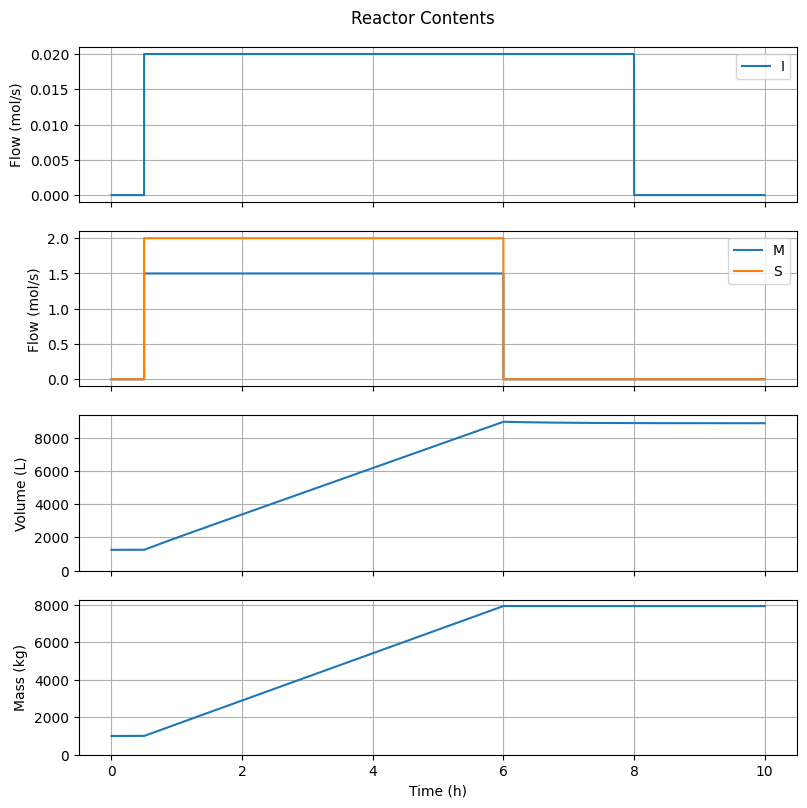

In [10]:
fig1, ax = plt.subplots(4, 1, sharex=True, figsize=(8, 8))
fig1.suptitle("Reactor Contents".title())
fig1.tight_layout()

t_hour = t/3600

# Feed I
ax[0].plot(t_hour, ndot_in[idx_I, :], label="I")
ax[0].set_ylabel("Flow (mol/s)")
ax[0].grid(True)
ax[0].legend(loc='upper right')

# Feed others
ax[1].plot(t_hour, ndot_in[idx_M, :], label="M")
ax[1].plot(t_hour, ndot_in[idx_S, :], label="S")
ax[1].set_ylabel("Flow (mol/s)")
ax[1].grid(True)
ax[1].legend(loc='upper right')

# Volume
ax[2].plot(t_hour, V)
ax[2].set_ylabel("Volume (L)")
ax[2].set_ylim(0., None)
ax[2].grid(True)

# Mass
ax[3].plot(t_hour, m_t)
ax[3].set_ylabel("Mass (kg)")
ax[3].set_ylim(0., None)
ax[3].grid(True)

ax[-1].set_xlabel("Time (h)")

#### Species Amounts & Concentrations

Text(0.5, 58.7222222222222, 'Time (h)')

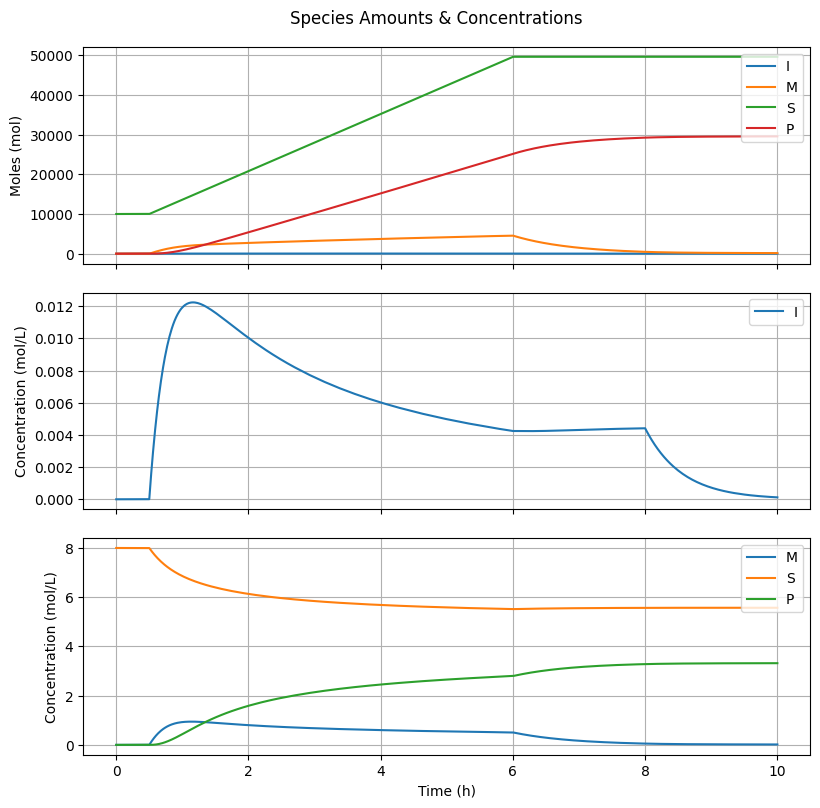

In [11]:
fig2, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 8))
fig2.suptitle("Species amounts & concentrations".title())
fig2.tight_layout()

# Number of moles
ax[0].plot(t_hour, n[idx_I, :], label="I")
ax[0].plot(t_hour, n[idx_M, :], label="M")
ax[0].plot(t_hour, n[idx_S, :], label="S")
ax[0].plot(t_hour, n[idx_mu1, :] + n[idx_ld1, :], label="P")
ax[0].set_ylabel("Moles (mol)")
ax[0].grid(True)
ax[0].legend(loc='upper right')

# Molar concentration I
ax[1].plot(t_hour, C[idx_I, :], label="I")
ax[1].set_ylabel("Concentration (mol/L)")
ax[1].grid(True)
ax[1].legend(loc='upper right')

# Molar concentrations others
ax[2].plot(t_hour, C[idx_M, :], label="M")
ax[2].plot(t_hour, C[idx_S, :], label="S")
ax[2].plot(t_hour, C[idx_mu1, :] + C[idx_ld1, :], label="P")
ax[2].set_ylabel("Concentration (mol/L)")
ax[2].grid(True)
ax[2].legend(loc='upper right')

ax[-1].set_xlabel("Time (h)")

#### Average Chain Length

Text(0.5, 36.72222222222221, 'Time (h)')

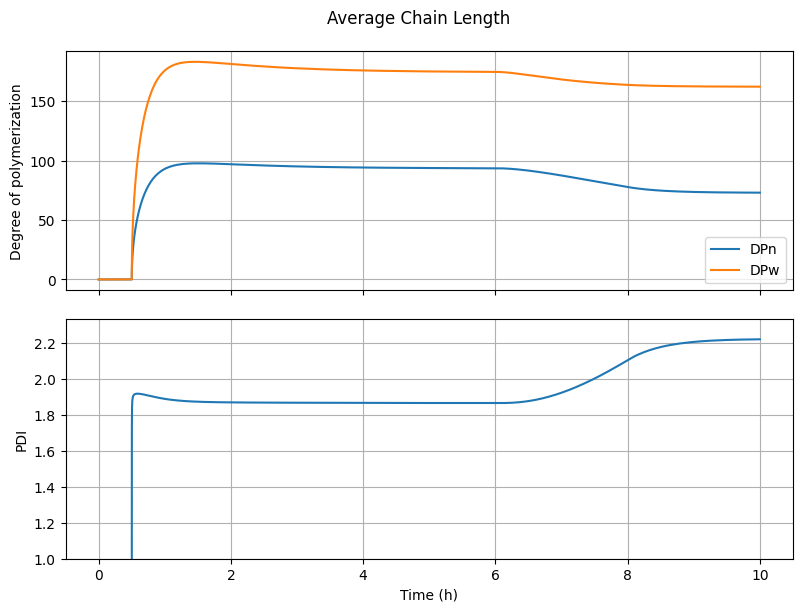

In [12]:
fig3, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
fig3.suptitle("Average chain length".title())
fig3.tight_layout()

# DPn and DPn
DPn = (n[idx_mu1, :] + n[idx_ld1, :])/(n[idx_mu0, :] + n[idx_ld0, :] + 1e-10)
DPw = (n[idx_mu2, :] + n[idx_ld2, :])/(n[idx_mu1, :] + n[idx_ld1, :] + 1e-10)
ax[0].plot(t_hour, DPn, label="DPn")
ax[0].plot(t_hour, DPw, label="DPw")
ax[0].set_ylabel("Degree of polymerization")
ax[0].grid(True)
ax[0].legend(loc='best')

# PDI
PDI = DPw/(DPn + 1e-10)
ax[1].plot(t_hour, PDI)
ax[1].set_ylabel("PDI")
ax[1].set_ylim(1., None)
ax[1].grid(True)

ax[-1].set_xlabel("Time (h)")

### Temperature & Safety

Text(0.5, 23.52222222222222, 'Time (h)')

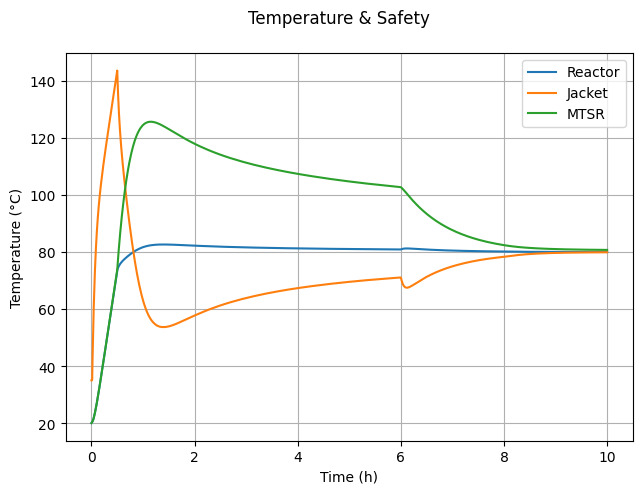

In [13]:
fig4, ax = plt.subplots(1, 1)
fig4.suptitle("Temperature & safety".title())
fig4.tight_layout()

# Temperatures
ax.plot(t_hour, T, label="Reactor")
ax.plot(t_hour, Tj, label="Jacket")
ax.plot(t_hour, MTSR, label="MTSR")
ax.set_ylabel("Temperature (°C)")
ax.grid(True)
ax.legend()
ax.set_xlabel("Time (h)")

## Questions/Extras

1. Why is there a maximum in $[I]$ if the initiator feed rate is actually constant?
2. What happens to $PDI$ when the parameter `alpha` is set to 0 or 1? Explain why this occurs.
3. Why is the MTSR highest at the start of the feed period? What can be done to reduce it?
4. Why does the jacket temperature suddenly drop at 6 hours?
5. What changes occur in the jacket temperature between approximately 1 hour and 6 hours?
6. The current heat transfer model assumes a constant overall heat transfer coefficient, $U$. What are your thoughts on this assumption?
7. Can you propose an empirical or semi-theoretical expression to describe the evolution of $U$ during the run?
8. Implement the model proposed in Question 7.
